In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# load data
sp500 = pd.read_csv("sp500_data_cleaned.csv", header=[0,1], index_col=0)

# confirm
sp500.head()

Price,Close,High,Low,Open,Volume,Log Returns
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,-0.018447
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,-0.008933
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,0.011563
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,0.017730
2015-01-09,2044.810059,2064.429932,2038.329956,2063.449951,3364140000,-0.008439


In [2]:
# seperate the returns
returns = sp500[('Log Returns', '^GSPC')]

# summary
print(returns.describe())

count    2515.000000
mean        0.000417
std         0.011270
min        -0.127652
25%        -0.003783
50%         0.000636
75%         0.005739
max         0.089683
Name: (Log Returns, ^GSPC), dtype: float64


## Historical VaR:
Given N past daily returns, the 5th percentile will simply be the daily VaR at 95% one tail. Need to rank the returns from best to worst. Then let's say we have N = 500, the 95th of that will be the 25th worse return, and the 99th will be the 5th worse day. 

In [3]:
confidence_level = 0.95
percentile = (1 - confidence_level) * 100  # 5 for 95% VaR

# historical VaR, and - for sign universality
historical_VaR = -np.percentile(returns, percentile)
print(f"Historical 1-day {int(confidence_level*100)}% VaR: {historical_VaR*100:.2f}%")

Historical 1-day 95% VaR: 1.70%


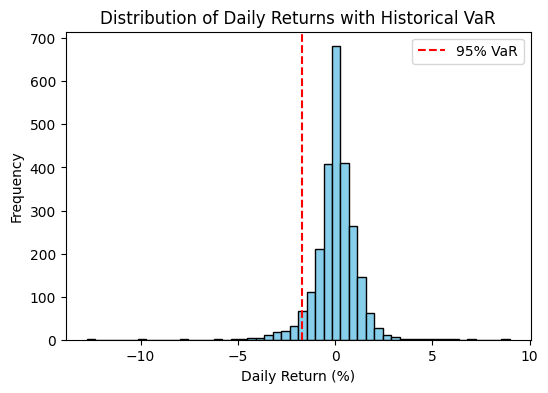

In [4]:
plt.figure(figsize=(6,4))
plt.hist(returns * 100, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x = returns.quantile(1 - confidence_level) * 100, color='red', linestyle='--', label=f'{int(confidence_level*100)}% VaR')
plt.legend()
plt.title('Distribution of Daily Returns with Historical VaR')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()

## Parametric VaR:
Assume normal distribution of returns, and then apply the same principles as the historical returns. Not realistic because returns have fat tails and don't closely follow normal curves. mu here is the average daily return for N days, and sigma is the standard deviation. 

In [5]:
mu = returns.mean()
sigma = returns.std()

In [6]:
# z for 95th percentile
z_95 = norm.ppf(1 - confidence_level)  # negative value (~ -1.645 for 95%)

# Parametric VaR = -(mu + z * sigma)
parametric_VaR = -(mu + z_95 * sigma)
print(f"Parametric 1-day {int(confidence_level*100)}% VaR: {parametric_VaR*100:.2f}%")

Parametric 1-day 95% VaR: 1.81%


## Monte Carlo:
Monte Carlo allows randomized simulations. But in our case we are assuming a normal distribution model underneath, so we should expect results similar to our Parametric VaR. 

In [7]:
# seed
np.random.seed(42)

# number of sims
n_simulations = 10000

df = 5  # degrees of freedom
sim_returns = np.random.standard_t(df, n_simulations) * sigma / np.sqrt(df / (df - 2)) + mu

# 5th percentile of the simulated returns and report as positive loss
monte_carlo_VaR = -np.percentile(sim_returns, percentile)
print(f"Monte Carlo 1-day {int(confidence_level*100)}% VaR: {monte_carlo_VaR*100:.2f}%")

Monte Carlo 1-day 95% VaR: 1.72%


In [8]:
print(f"Historical VaR: {historical_VaR*100:.2f}%")
print(f"Parametric VaR: {parametric_VaR*100:.2f}%")
print(f"Monte Carlo VaR: {monte_carlo_VaR*100:.2f}%")

Historical VaR: 1.70%
Parametric VaR: 1.81%
Monte Carlo VaR: 1.72%


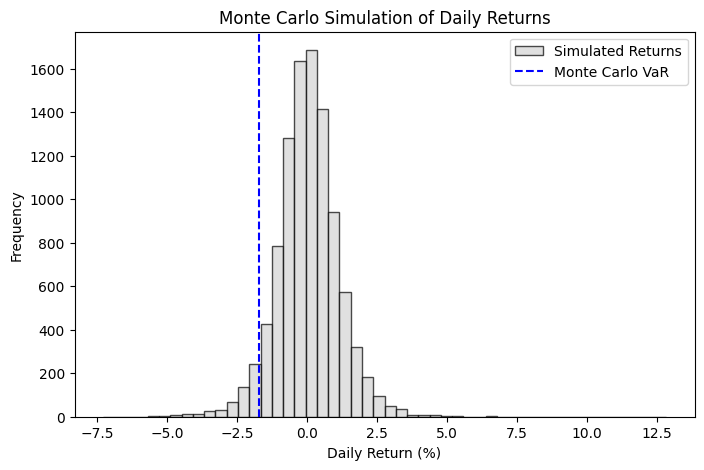

In [9]:
plt.figure(figsize=(8,5))
plt.hist(sim_returns * 100, bins=50, color='lightgrey', edgecolor='black', alpha=0.7, label="Simulated Returns")
plt.axvline(x = np.percentile(sim_returns, percentile) * 100, color='blue', linestyle='--', label="Monte Carlo VaR")
plt.title('Monte Carlo Simulation of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()